#  Introduction:
### Context
The original dataset contains 1000 entries with 20 categorial/symbolic attributes prepared by Prof. Hofmann. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes. 
### Content

Age (numeric)

Sex (text: male, female)

Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)

Housing (text: own, rent, or free)

Saving accounts (text - little, moderate, quite rich, rich)

Checking account (numeric, in DM - Deutsch Mark)

Credit amount (numeric, in DM)

Duration (numeric, in month)

Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

# Libraries and Data 

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [35]:
df = pd.read_csv("german_credit_data_risk.csv")
df.head(15)

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad
5,5,35,male,1,free,NaN,NaN,9055,36,education,good
6,6,53,male,2,own,quite rich,NaN,2835,24,furniture/equipment,good
7,7,35,male,3,rent,little,moderate,6948,36,car,good
8,8,61,male,1,own,rich,NaN,3059,12,radio/TV,good
9,9,28,male,3,own,little,moderate,5234,30,car,bad


In [36]:
df=df.iloc[:,1:len(df)]
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [37]:
df.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


In [38]:
df.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


* There are missing values in columns "Saving accounts" and "Checking accounts".
* We will fill in the blanks as "unknown".

In [40]:
df['Saving accounts'] = df['Saving accounts'].fillna('unknown')
df['Checking account'] = df['Checking account'].fillna('unknown')

In [41]:
numeric = ['Age', 'Job', 'Credit amount', 'Duration']
categorical = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose',"Risk"]

In [42]:
df["Sex"].value_counts()

male      690
female    310
Name: Sex, dtype: int64

In [43]:
df["Job"].value_counts()  # Actually Job is a categorical variable

2    630
1    200
3    148
0     22
Name: Job, dtype: int64

In [44]:
df["Housing"].value_counts()

own     713
rent    179
free    108
Name: Housing, dtype: int64

In [45]:
df["Purpose"].value_counts()

car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
vacation/others         12
domestic appliances     12
Name: Purpose, dtype: int64

In [46]:
df["Saving accounts"].value_counts()

little        603
unknown       183
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64

In [47]:
df["Checking account"].value_counts()

unknown     394
little      274
moderate    269
rich         63
Name: Checking account, dtype: int64

In [48]:
df["Risk"].value_counts()

good    700
bad     300
Name: Risk, dtype: int64

# Visualization

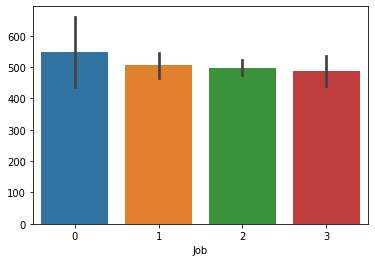

In [49]:
sns.barplot(x = "Job", y = df.Job.index, data= df);

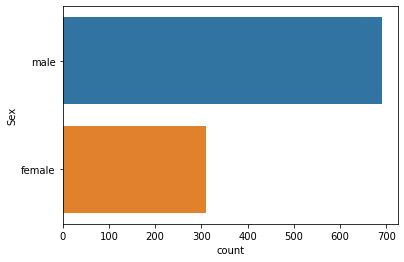

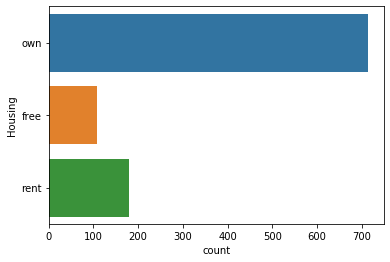

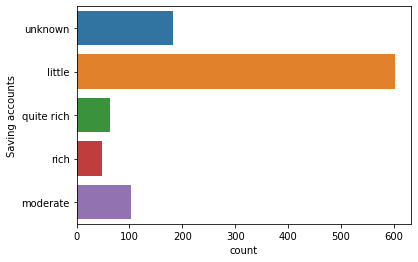

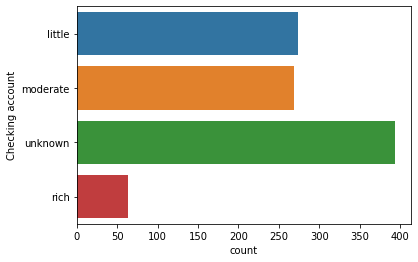

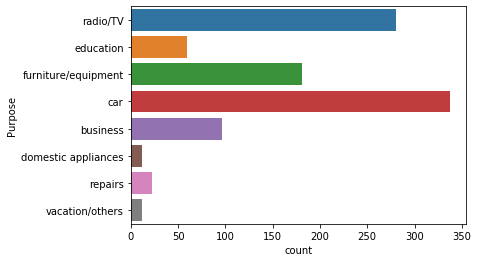

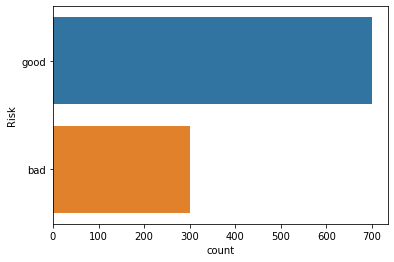

In [50]:
for col in df[categorical].columns:
    sns.countplot(y =col, data = df)
    plt.show()

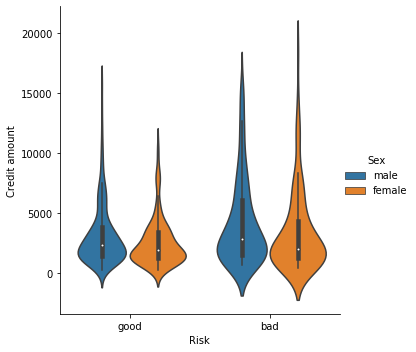

In [51]:
sns.catplot(x= "Risk", y = "Credit amount", hue = "Sex",kind = "violin", data = df);

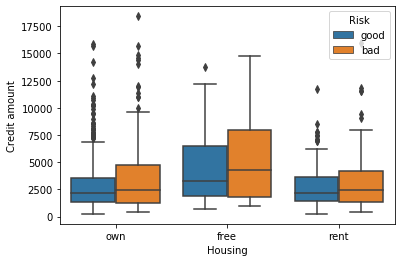

In [52]:
sns.boxplot(x = "Housing", y = "Credit amount", hue = "Risk", data = df);

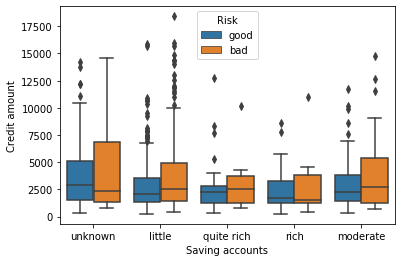

In [53]:
sns.boxplot(x = "Saving accounts", y = "Credit amount", hue = "Risk", data = df);

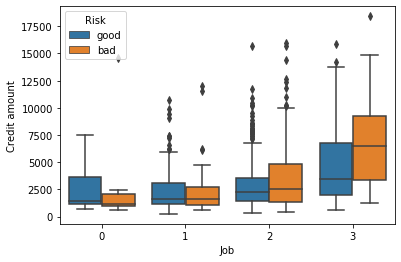

In [54]:
sns.boxplot(x = "Job", y = "Credit amount", hue = "Risk", data = df);

# Encode

In [55]:
data=df.copy()

In [56]:
encoder = LabelEncoder()
from sklearn.preprocessing import LabelEncoder
for label in categorical:
    data[label] = encoder.fit_transform(data[label])

In [57]:
data[categorical]

,Sex,Housing,Saving accounts,Checking account,Purpose,Risk
0,1,1,4,0,5,1
1,0,1,0,1,5,0
2,1,1,0,3,3,1
3,1,0,0,0,4,1
4,1,0,0,0,1,0
...,...,...,...,...,...,...
995,0,1,0,3,4,1
996,1,1,0,0,1,1
997,1,1,0,3,5,1
998,1,0,0,0,5,0


In [58]:
data = pd.get_dummies(data, columns = ["Housing"])
data = pd.get_dummies(data, columns = ["Saving accounts"], prefix="Sav")
data = pd.get_dummies(data, columns = ["Checking account"], prefix="Check")
data = pd.get_dummies(data, columns = ["Purpose"], prefix="Pur")

In [59]:
data.head(5)

,Age,Sex,Job,Credit amount,Duration,Risk,Housing_0,Housing_1,Housing_2,Sav_0,...,Check_2,Check_3,Pur_0,Pur_1,Pur_2,Pur_3,Pur_4,Pur_5,Pur_6,Pur_7
0,67,1,2,1169,6,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,22,0,2,5951,48,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
2,49,1,1,2096,12,1,0,1,0,1,...,0,1,0,0,0,1,0,0,0,0
3,45,1,2,7882,42,1,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,53,1,2,4870,24,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [60]:
data["Risk"].value_counts()

1    700
0    300
Name: Risk, dtype: int64

# Modeling

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = data.drop(['Risk'], axis=1).values
Y = data["Risk"].values
    
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size = 0.20, 
                                                    random_state = 42)

In [62]:
def base_models(df):
    
    
    
    #results = []
    
    names = ["LogisticRegression","GaussianNB","KNN","LinearSVC","SVC",
             "CART","RF","GBM","XGBoost","LightGBM","CatBoost"]
    
    
    classifiers = [LogisticRegression(),GaussianNB(), KNeighborsClassifier(),LinearSVC(),SVC(),
                  DecisionTreeClassifier(),RandomForestClassifier(), GradientBoostingClassifier(),
                  XGBClassifier(), LGBMClassifier(), CatBoostClassifier(verbose = False)]
    
    
    for name, clf in zip(names, classifiers):

        model = clf.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        msg = "%s: %f" % (name, acc)
        print(msg)

In [63]:
base_models(data)

LogisticRegression: 0.750000
GaussianNB: 0.660000
KNN: 0.680000
LinearSVC: 0.710000
SVC: 0.715000
CART: 0.675000
RF: 0.760000
GBM: 0.780000
XGBoost: 0.775000
LightGBM: 0.785000
CatBoost: 0.775000


# Model Tuning

In [64]:
xgb_params = {
        'n_estimators': [100, 500, 1000],
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5,6],
        'learning_rate': [0.1,0.01,0.02,0.05],
        "min_samples_split": [2,5,10]}
xgb = XGBClassifier()

xgb_cv_model = GridSearchCV(xgb, xgb_params, cv = 10, n_jobs = -1, verbose = 2)
xgb_cv_model.fit(X_train, y_train)

Fitting 10 folds for each of 432 candidates, totalling 4320 fits


GridSearchCV(cv=10, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.02, 0.05],
                         'max_depth': [3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 500, 1000],
                         'subsample': [0.6, 0.8, 1.0]},
             verbose=2)

In [65]:
xgb_cv_model.best_params_

{'learning_rate': 0.02,
 'max_depth': 6,
 'min_samples_split': 2,
 'n_estimators': 1000,
 'subsample': 0.6}

In [66]:
xgb = XGBClassifier(learning_rate = 0.02, 
                    max_depth = 6,
                    min_samples_split = 2,
                    n_estimators = 1000,
                    subsample = 0.6)
xgb_tuned =  xgb.fit(X_train,y_train)
y_pred = xgb_tuned.predict(X_test)
accuracy_score(y_test, y_pred)

0.795

Accuracy: 0.795
Precision: 0.7863
Recall: 0.795
F1 Score: 0.7836
Cohen Kappa Score: 0.4621
Matthews Corrcoef: 0.474
roc_auc_score: 0.7116840966462314
		Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.71      0.59        42
           1       0.91      0.82      0.86       158

    accuracy                           0.80       200
   macro avg       0.71      0.77      0.73       200
weighted avg       0.83      0.80      0.81       200

Confusion Matrix:
 [[ 30  29]
 [ 12 129]]


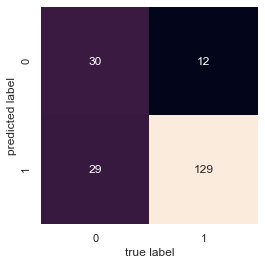

In [67]:
#Evaluate the Model and Print Performance Metrics
from sklearn import metrics
print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred,average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test, y_pred,
                                               average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred,
                                               average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('Matthews Corrcoef:', np.round(metrics.matthews_corrcoef(y_test, y_pred),4)) 

from sklearn.metrics import roc_auc_score
print("roc_auc_score:", roc_auc_score(y_test, y_pred, average=None))

print('\t\tClassification Report:\n', metrics.classification_report(y_pred,y_test))


from sklearn.metrics import confusion_matrix
print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred))


#Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
from io import BytesIO #neded for plot
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

plt.savefig("Confusion.jpg")
# Save SVG in a fake file object.
f = BytesIO()
plt.savefig(f, format="svg")

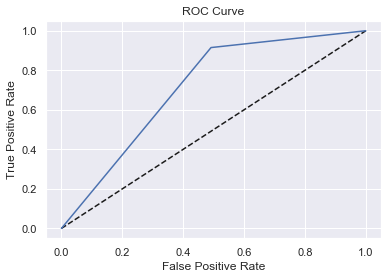

In [68]:
# # Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# # Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()